### LSTM Model with features

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation_v2
from features import get_apple_stock_with_features

In [26]:
important_cols = ['Open', 
                  'High', 
                  'Low', 
                  'Close', # <-- our target (pos=3)
#                   'Close_ndx',
                  'kc_10',
                  'ema_26', 
#                   'ema_12', 
#                   'macd',
#                   'macd_diff',
#                   'macd_sig',
                  'mavg_200', 
                  'mavg_50', 
#                   'mavg_20', 
#                   'mavg_10', 
#                   'b_hband_20', 
#                   'b_lband_20', 
#                   'ao', 
#                   'ichimoku_a', 
#                   'kc_lband_10',
#                   'dc_lband_20',
#                   'dc_hband_20', 
# #                   'tsi', 
#                   'nvi', 
#                   'mi',
#                   'atr_14'
                 ]
apple_stock = get_apple_stock_with_features(important_cols)

In [27]:
short_series = get_range(apple_stock, '2003-01-01')

In [28]:
# Model parameters
look_back = 5 # days window look back
n_features = len(short_series.columns.values)
n_outputs = 5 # days forecast
batch_size = 32 # for NN, batch size before updating weights
n_epochs = 100 # for NN, number of training epochs

We need to first train/test split, then transform and scale our data

In [29]:
train, test = train_test_split(short_series,'2018-05-31')

In [30]:
from sklearn.preprocessing import PowerTransformer

In [31]:
# we need to use yeo-johnson transformation since we have negative values
# pt = PowerTransformer(method='box-cox')
pt = PowerTransformer(method='yeo-johnson')

In [32]:
transformed_train = pt.fit_transform(train.values)
transformed_test = pt.transform(test.values)

# transformed_train = train.values
# transformed_test = test.values

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
scaler = MinMaxScaler()

In [35]:
scaled_train = scaler.fit_transform(transformed_train)
scaled_test = scaler.transform(transformed_test)

In [36]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)

# we're only interested in the Close price (pos=3)
y_train = y_train[:, :, 3]

In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, LeakyReLU
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

In [38]:
def build_LSTM(look_back, n_features, n_outputs, optimizer='adam'):
    model = Sequential()

    model.add(LSTM(50, 
                   activation='relu', 
                   input_shape=(look_back, n_features)))
    model.add(Dense(n_outputs))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [39]:
model = build_LSTM(look_back, n_features, n_outputs)

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
Total params: 12,055
Trainable params: 12,055
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/100
3871/3871 [==============================] - 2s 456us/step - loss: 0.0012
Epoch 2/100
3871/3871 [==============================] - 1s 291us/step - loss: 0.0013
Epoch 3/100
3871/3871 [==============================] - 1s 291us/step - loss: 6.7854e-04
Epoch 4/100
3871/3871 [==============================] - 1s 290us/step - loss: 4.1396e-04
Epoch 5/100
3871/3871 [==============================] - 1s 290us/step - loss: 3.8704e-04
Epoch 6/100
3871/3871 [==============================] - 1s 296us/step - loss: 3.9808e-04
Epoch 7/100
3871/3871 [==============================] - 1s 293us/step - loss: 3.8351e-04
Epoch 8/100
3871/3871 [==============================] - 1s 291us/step - loss: 3.8005e-04
Epoch 9/100
3871/3871 [==============================] - 1s 291us/step - loss: 3.6271e-04
Epoch 10/100
3871/3871 [==============================] - 1s 296us/step - loss: 3.5755e-04
Epoch 11/100
3871/3871 [==============================] - 1s 290us/step - loss: 3.4909e-04
Epoch 12/100
387

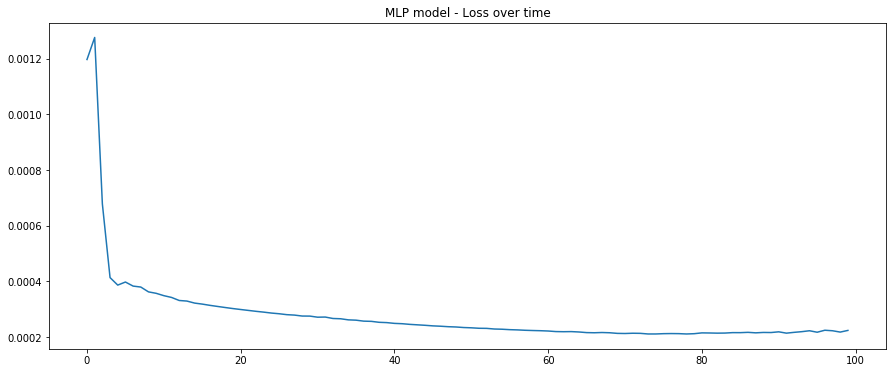

In [46]:
plot_series(history.history['loss'], title='MLP model - Loss over time')

In [47]:
model.save_weights('lstm-model_weights.h5')

In [48]:
size = 252 # approx. one year
predictions = NN_walk_forward_validation_v2(model, 
                                            scaled_train, scaled_test[:252], 
                                            size=size, 
                                            look_back=look_back, 
                                            n_features=n_features, 
                                            n_outputs=n_outputs)

In [49]:
from utils import plot_walk_forward_validation, descale_with_features
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [50]:
descaled_preds, descaled_test = descale_with_features(predictions, 
                                                      scaled_test, 
                                                      n_features, 
                                                      scaler=scaler, 
                                                      transformer=pt)

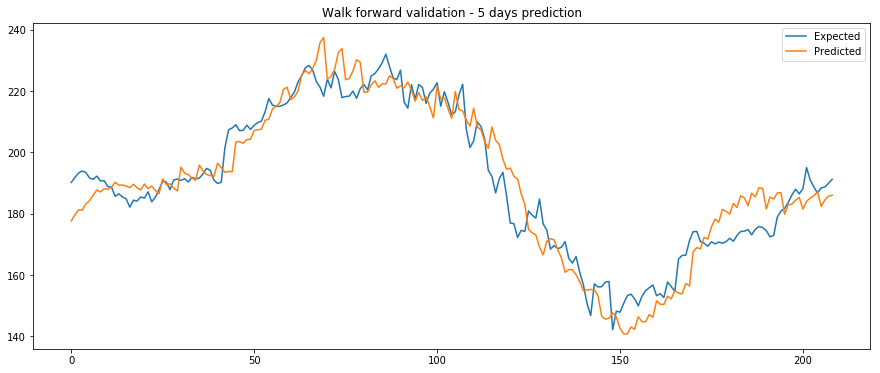

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size][:, 3])
plt.plot(descaled_preds)
ax.set_title('Walk forward validation - 5 days prediction')
ax.legend(['Expected', 'Predicted'])

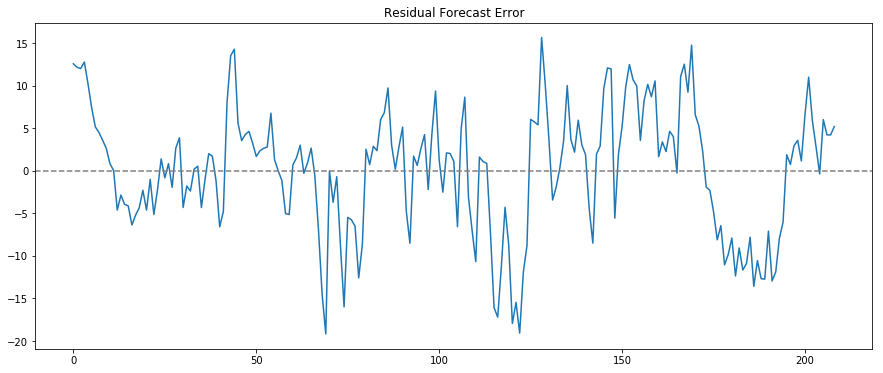

In [52]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size][:, 3])

In [53]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size][:, 3],
                          model_name='MLP with features', 
                          total_days=size, steps=n_outputs)

MLP with features[252 days, 5 days forecast]:

Forecast Bias: 0.035
MAE: 5.810
MSE: 53.192
RMSE: 7.293
MAPE: 3.154


In [58]:
model.load_weights('mlp-model_weights.h5')